Our goal is to predict whether or not a loan will be paid in full or charged off. We will be using pyspark ML algorithms in order to build models and compare the performance of each models.

In [1]:
import pandas as pd
import numpy as np
#import missingno as msno
import matplotlib.pyplot as plt

In [2]:
# Load dataset first as a pandas DF due to schema errors
data = pd.read_csv('data/loan.csv')

/home/erik_r_su/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


First, let's look at our data and see what features we need to remove or clean.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 74 columns):
id                             887379 non-null int64
member_id                      887379 non-null int64
loan_amnt                      887379 non-null float64
funded_amnt                    887379 non-null float64
funded_amnt_inv                887379 non-null float64
term                           887379 non-null object
int_rate                       887379 non-null float64
installment                    887379 non-null float64
grade                          887379 non-null object
sub_grade                      887379 non-null object
emp_title                      835917 non-null object
emp_length                     842554 non-null object
home_ownership                 887379 non-null object
annual_inc                     887375 non-null float64
verification_status            887379 non-null object
issue_d                        887379 non-null object
loan_status          

In [4]:
#%matplotlib inline
# The msno.matrix nullity matrix is a data-dense display which lets you quickly
# and visually pick out patterns in data completion.

#msno.matrix(data)  

We can see that some features have missing values, so we need to account for those in some way. A simple calculation of the proporition of missing values along with a threshold will reduce the total number of features. But before that, we inspect the features manually to see if any features that have a large portion of missing values are relevant to our predictor. 

By inspection, we see that the 'months since last record', 'months since last major derog', and 'months since last delinquence' fit this criteria. We fill in the missing values with '0's. 

In [5]:
#b. mths_since_last_record: The number of months since the last public record.
#c. mths_since_last_major_derog: Months since most recent 90-day or worse rating
#d. mths_since_last_delinq: The number of months since the borrower's last delinquency.    
#can not be dropped, I guess the missing values should be replaced with "0" ***need further verification***
values = {'mths_since_last_record': 0, 'mths_since_last_major_derog': 0, 'mths_since_last_delinq': 0}

data = data.fillna(value=values)

We also want to merge all the loan_status values into either a 'good' loan or a 'bad' loan.

In [6]:
status_replace = {"loan_status" : { 'Current':0,'Issued':0,'Fully Paid':0,'In Grace Period':1,
                                   'Does not meet the credit policy. Status:Fully Paid':0,
                                   'Does not meet the credit policy. Status:Charged Off':1,
                                   'Default':1,
                                   'Late (31-120 days)':1,'Late (16-30 days)':1,'Charged Off':1 }}
                  #The Current is a great portion of the data, maybe we can do like this. "Good debt" vs "Bad debt"
data =data.replace(status_replace)

Now let's calculate the missing portions for each feature and apply a threshold to drop such features.

In [7]:
# Calculate proportion of missing values
missing_portion = data.isnull().sum()/len(data)
print(missing_portion.sort_values(ascending=False))

# Decide on threshold
threshold = 0.2

# Split list based off threshold 
drop_list = [missing_portion.index[x] for x in range(0,len(missing_portion)) if missing_portion[x] > threshold]

print('These are the features with over ' + str(threshold*100) + '% of the data missing:')
print(drop_list)

dti_joint                      0.999426
annual_inc_joint               0.999424
verification_status_joint      0.999424
il_util                        0.979020
mths_since_rcnt_il             0.976549
total_cu_tl                    0.975916
open_acc_6m                    0.975916
open_il_6m                     0.975916
open_il_12m                    0.975916
open_il_24m                    0.975916
inq_last_12m                   0.975916
open_rv_12m                    0.975916
open_rv_24m                    0.975916
max_bal_bc                     0.975916
all_util                       0.975916
inq_fi                         0.975916
total_bal_il                   0.975916
desc                           0.857977
next_pymnt_d                   0.285077
total_rev_hi_lim               0.079195
tot_cur_bal                    0.079195
tot_coll_amt                   0.079195
emp_title                      0.057993
emp_length                     0.050514
last_pymnt_d                   0.019900


Now we should drop these columns along with any observations with missing values in general.

In [8]:
# Drop missing values features and any rows with NaNs
df1 = data.drop(drop_list, axis=1).dropna()

# Also drop 'id' and 'member_id'
df1 = df1.drop(['id', 'member_id'], axis=1)

df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 752938 entries, 42535 to 887378
Data columns (total 53 columns):
loan_amnt                      752938 non-null float64
funded_amnt                    752938 non-null float64
funded_amnt_inv                752938 non-null float64
term                           752938 non-null object
int_rate                       752938 non-null float64
installment                    752938 non-null float64
grade                          752938 non-null object
sub_grade                      752938 non-null object
emp_title                      752938 non-null object
emp_length                     752938 non-null object
home_ownership                 752938 non-null object
annual_inc                     752938 non-null float64
verification_status            752938 non-null object
issue_d                        752938 non-null object
loan_status                    752938 non-null int64
pymnt_plan                     752938 non-null object
url             

Let's make sure that there are no missing values in our data again.

In [9]:
#msno.matrix(df1) 

From here we can see we have multiple datatypes which needs to be separated into all numerics to be used for algorithms and plots.

In [10]:
# split according to datatypes (numeric vs string)
numeric_pd = df1.select_dtypes(include='number')
string_pd = df1.select_dtypes(exclude='number')

numeric_pd.info()
string_pd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 752938 entries, 42535 to 887378
Data columns (total 34 columns):
loan_amnt                      752938 non-null float64
funded_amnt                    752938 non-null float64
funded_amnt_inv                752938 non-null float64
int_rate                       752938 non-null float64
installment                    752938 non-null float64
annual_inc                     752938 non-null float64
loan_status                    752938 non-null int64
dti                            752938 non-null float64
delinq_2yrs                    752938 non-null float64
inq_last_6mths                 752938 non-null float64
mths_since_last_delinq         752938 non-null float64
mths_since_last_record         752938 non-null float64
open_acc                       752938 non-null float64
pub_rec                        752938 non-null float64
revol_bal                      752938 non-null float64
revol_util                     752938 non-null float64
total_a

Now we need to split the string dataframe into categorical and descriptor features by inspection.

It is unclear what dates would be considered for this instance. For now we will also separate datetime features from the 'string' features.

*From Original Data*

Categorical features:
1. term
2. grade
3. sub_grade
4. emp_length
5. home_ownership
6. verification_status
7. loan_status ( this is our desired prediction )
8. pymnt_plan
9. purpose
10. zip_code
11. addr_state
12. initial_list_status
13. application_type
14. verification_status_joint

Date features:
1. issue_d
2. earliest_cr_line
3. last_pymnt_d
4. next_pymnt_d
5. last_credit_pull_d

Descriptor features:
1. emp_title
2. url
3. desc
4. title

Now that we have split these by inspection, we split the 'string' dataFrame accordingly. 

In [14]:
# Notice that 'loan_status' is now in the numeric dataframe!

# Split string_df by inspection
categorical_cols = ['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership',\
                    'verification_status', 'pymnt_plan', 'purpose',\
                    'zip_code', 'addr_state', 'initial_list_status','application_type']#,\
                    #'verification_status_joint']

datetime_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d','last_credit_pull_d']#, 'next_pymnt_d']

descript_cols = ['emp_title', 'url', 'title']#,'desc']


categorical_pd = string_pd.loc[:, categorical_cols]
datetime_pd = string_pd.loc[:, datetime_cols]
descriptor_pd = string_pd.loc[:, descript_cols]

categorical_pd.info()
datetime_pd.info()
descriptor_pd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 752938 entries, 42535 to 887378
Data columns (total 12 columns):
term                   752938 non-null object
grade                  752938 non-null object
sub_grade              752938 non-null object
emp_length             752938 non-null object
home_ownership         752938 non-null object
verification_status    752938 non-null object
pymnt_plan             752938 non-null object
purpose                752938 non-null object
zip_code               752938 non-null object
addr_state             752938 non-null object
initial_list_status    752938 non-null object
application_type       752938 non-null object
dtypes: object(12)
memory usage: 74.7+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 752938 entries, 42535 to 887378
Data columns (total 4 columns):
issue_d               752938 non-null object
earliest_cr_line      752938 non-null object
last_pymnt_d          752938 non-null object
last_credit_pull_d    752938 non-null obje

Let's now take a closer look at the distribution of these features. For categorical data, we can use a bar graph. The goal of this analysis is to help determine what additional features we can drop before training our models.

Text(0.5,1,'application_type')

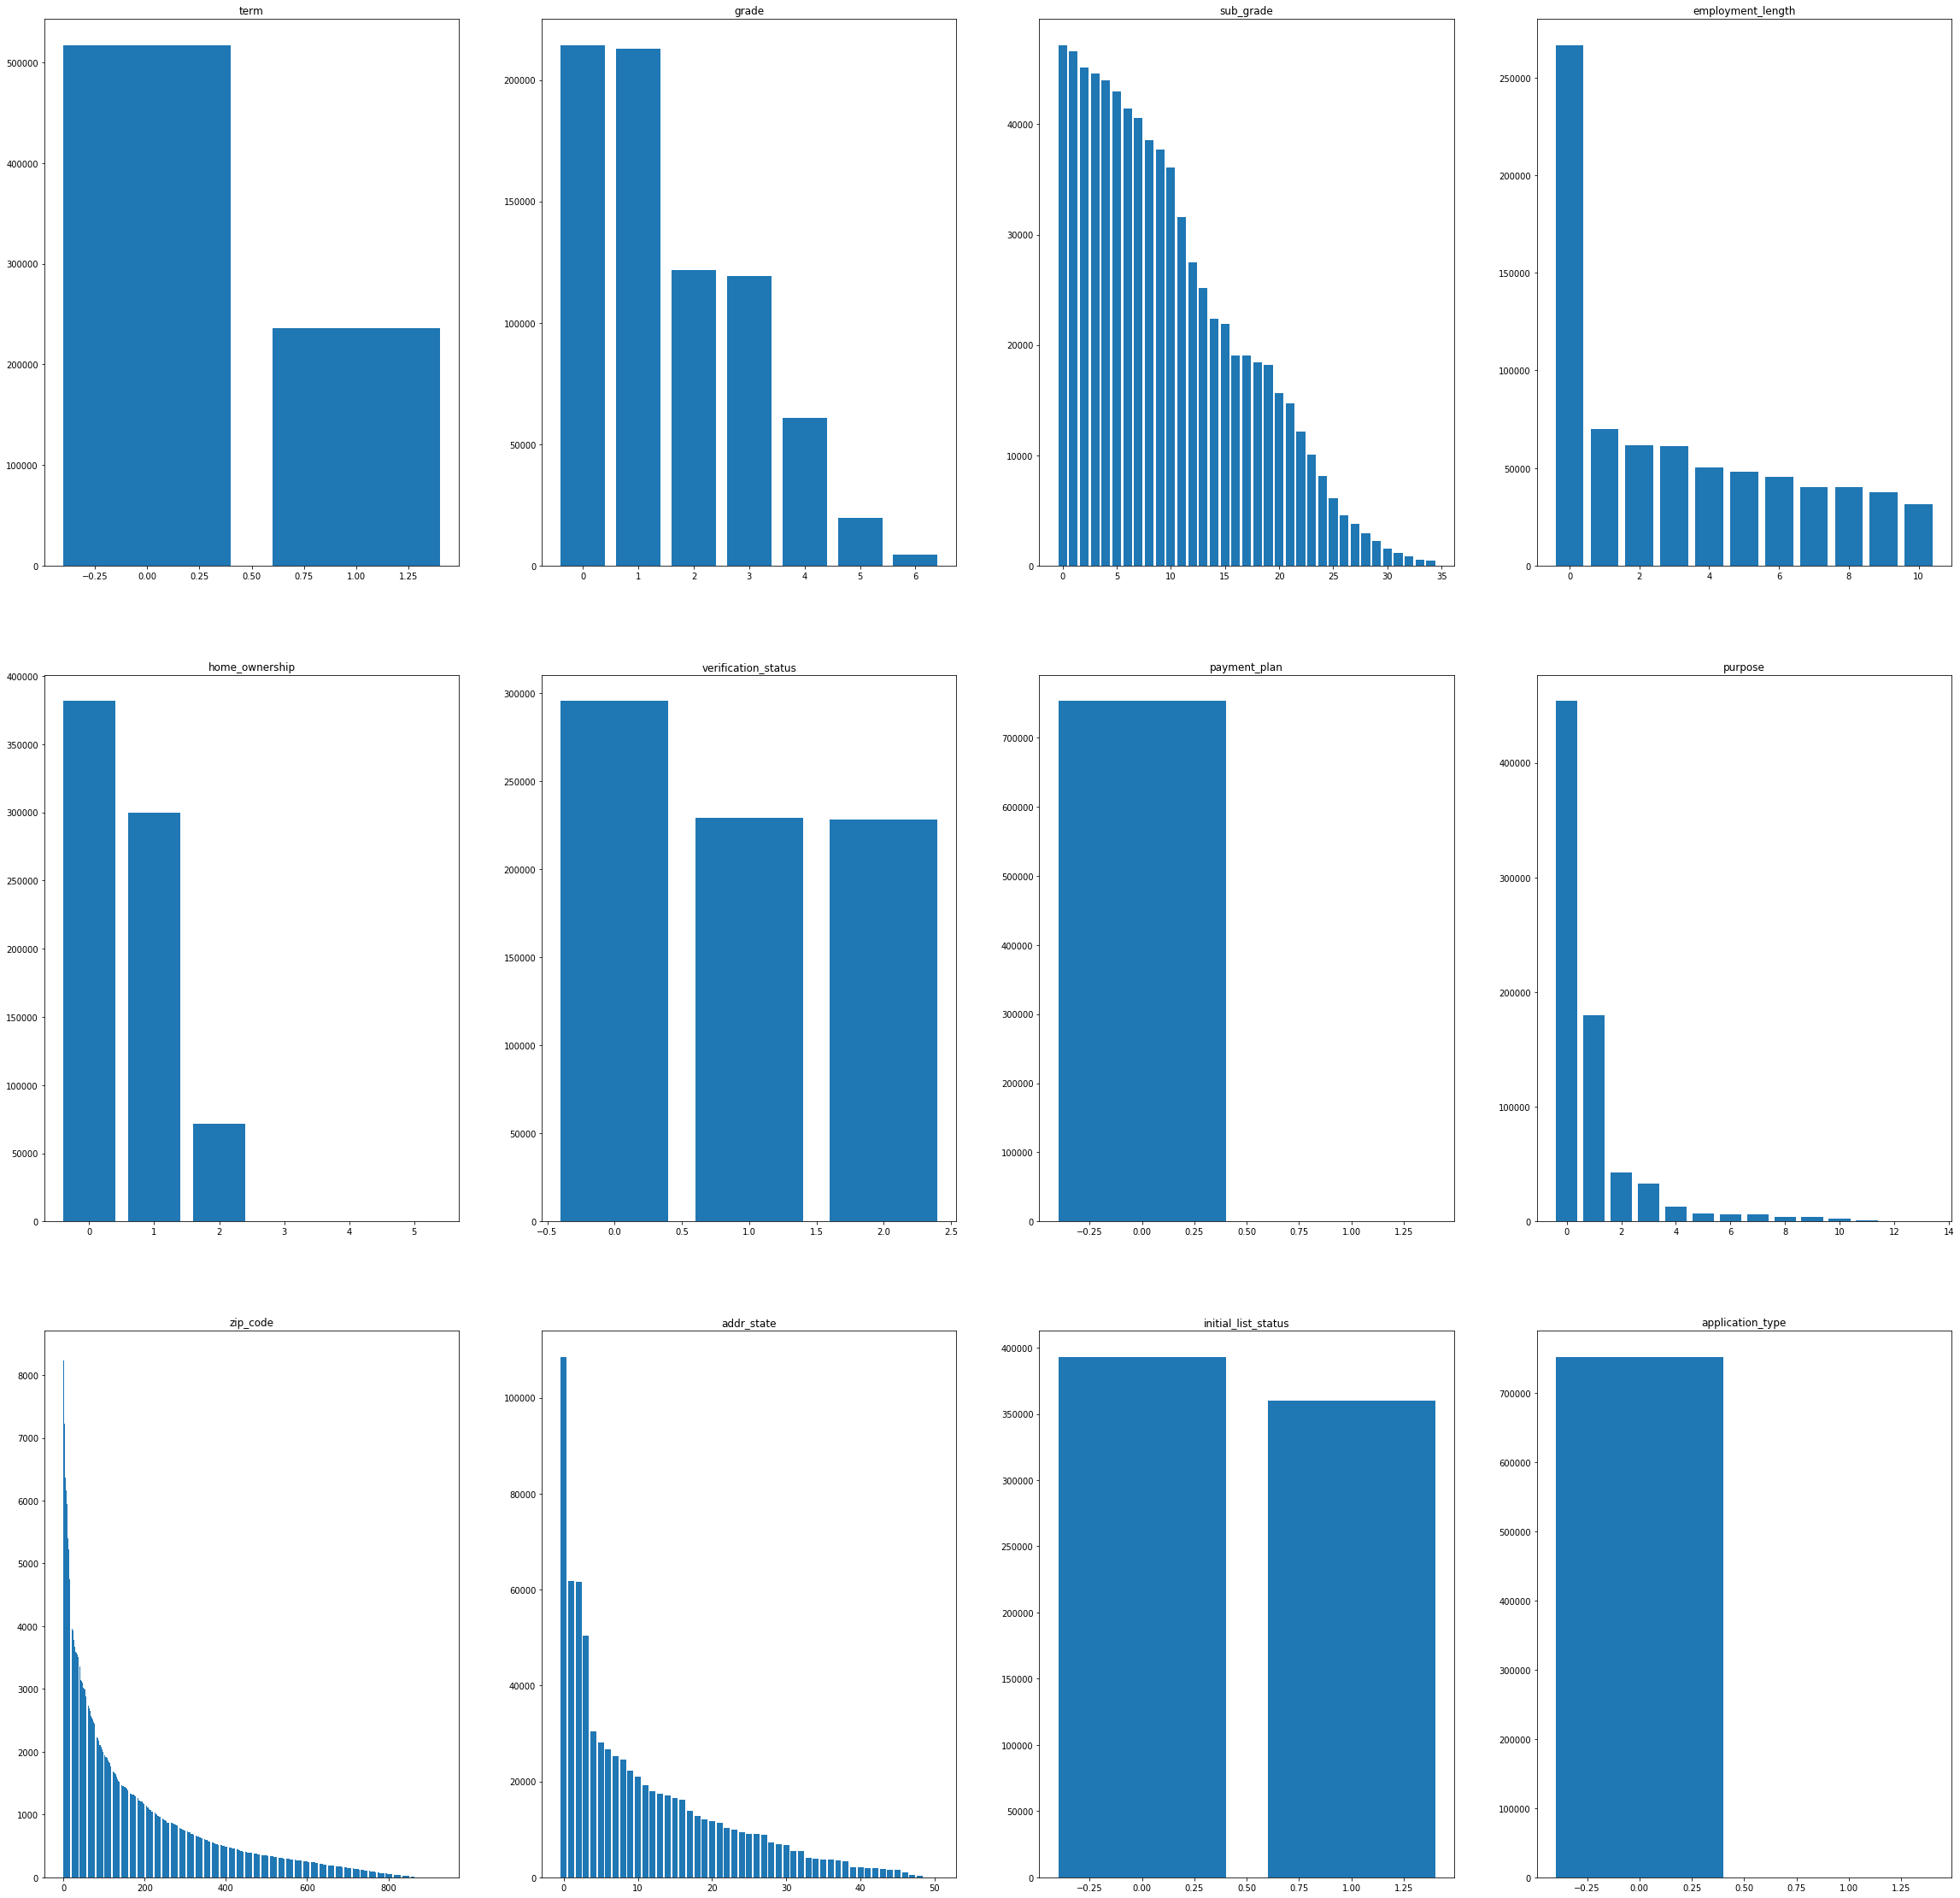

In [15]:
# Plot bar graphs of categorical features (value/index = 0 is the most frequent category)
plt.figure(figsize=(40,40))
plt.subplot(3,4,1)
plt.bar(range(0,len(categorical_pd.term.value_counts())),categorical_pd.term.value_counts())
plt.title('term')

plt.subplot(3,4,2)
plt.bar(range(0,len(categorical_pd.grade.value_counts())),categorical_pd.grade.value_counts())
plt.title('grade')

plt.subplot(3,4,3)
plt.bar(range(0,len(categorical_pd.sub_grade.value_counts())),categorical_pd.sub_grade.value_counts())
plt.title('sub_grade')

plt.subplot(3,4,4)
plt.bar(range(0,len(categorical_pd.emp_length.value_counts())),categorical_pd.emp_length.value_counts())
plt.title('employment_length')

plt.subplot(3,4,5)
plt.bar(range(0,len(categorical_pd.home_ownership.value_counts())),categorical_pd.home_ownership.value_counts())
plt.title('home_ownership')

plt.subplot(3,4,6)
plt.bar(range(0,len(categorical_pd.verification_status.value_counts())),categorical_pd.verification_status.value_counts())
plt.title('verification_status')

plt.subplot(3,4,7)
plt.bar(range(0,len(categorical_pd.pymnt_plan.value_counts())),categorical_pd.pymnt_plan.value_counts())
plt.title('payment_plan')

plt.subplot(3,4,8)
plt.bar(range(0,len(categorical_pd.purpose.value_counts())),categorical_pd.purpose.value_counts())
plt.title('purpose')

plt.subplot(3,4,9)
plt.bar(range(0,len(categorical_pd.zip_code.value_counts())),categorical_pd.zip_code.value_counts())
plt.title('zip_code')

plt.subplot(3,4,10)
plt.bar(range(0,len(categorical_pd.addr_state.value_counts())),categorical_pd.addr_state.value_counts())
plt.title('addr_state')

plt.subplot(3,4,11)
plt.bar(range(0,len(categorical_pd.initial_list_status.value_counts())),categorical_pd.initial_list_status.value_counts())
plt.title('initial_list_status')

plt.subplot(3,4,12)
plt.bar(range(0,len(categorical_pd.application_type.value_counts())),categorical_pd.application_type.value_counts())
plt.title('application_type')

In [16]:
# Display all categorical features counts (most frequent first)
#print(categorical_pd.term.value_counts())
#print(categorical_pd.grade.value_counts())
#print(categorical_pd.sub_grade.value_counts())
#print(categorical_pd.emp_length.value_counts())
#print(categorical_pd.home_ownership.value_counts())
#print(categorical_pd.verification_status.value_counts())
#print(categorical_pd.loan_status.value_counts())
#print(categorical_pd.pymnt_plan.value_counts())
#print(categorical_pd.purpose.value_counts())
#print(categorical_pd.zip_code.value_counts())
#print(categorical_pd.addr_state.value_counts())
#print(categorical_pd.initial_list_status.value_counts())
#print(categorical_pd.application_type.value_counts())

We will, for the moment, ignore datetimes and descriptor features as they are not as easily intrepretable and perhaps not useful in general. To look at the distribution of the numeric data, however, we want to plot histograms of the data as it is assumed to have a more continous behavior.

In [17]:
# plots for numeric stuff (not sure if neccessary since a heatmap would give us this as well)

For another step of preprocessing, we need to convert the categorical values into numerical values and concat with our numerical features (do we need to concat?). We can use this resultant dataframe in a heatmap analysis to remove highly correlated features. 

In [22]:
# Convert categorical data into numeric values using a LabelEncoder
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

for i in range(0, len(categorical_pd.columns)):
    categorical_pd.iloc[:,i] = le.fit_transform(categorical_pd.iloc[:,i])

# Concat categorical with numeric (do we need this?)
cat_num_pd = pd.concat([numeric_pd, categorical_pd], axis=1)
cat_num_pd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 752938 entries, 42535 to 887378
Data columns (total 46 columns):
loan_amnt                      752938 non-null float64
funded_amnt                    752938 non-null float64
funded_amnt_inv                752938 non-null float64
int_rate                       752938 non-null float64
installment                    752938 non-null float64
annual_inc                     752938 non-null float64
loan_status                    752938 non-null int64
dti                            752938 non-null float64
delinq_2yrs                    752938 non-null float64
inq_last_6mths                 752938 non-null float64
mths_since_last_delinq         752938 non-null float64
mths_since_last_record         752938 non-null float64
open_acc                       752938 non-null float64
pub_rec                        752938 non-null float64
revol_bal                      752938 non-null float64
revol_util                     752938 non-null float64
total_a

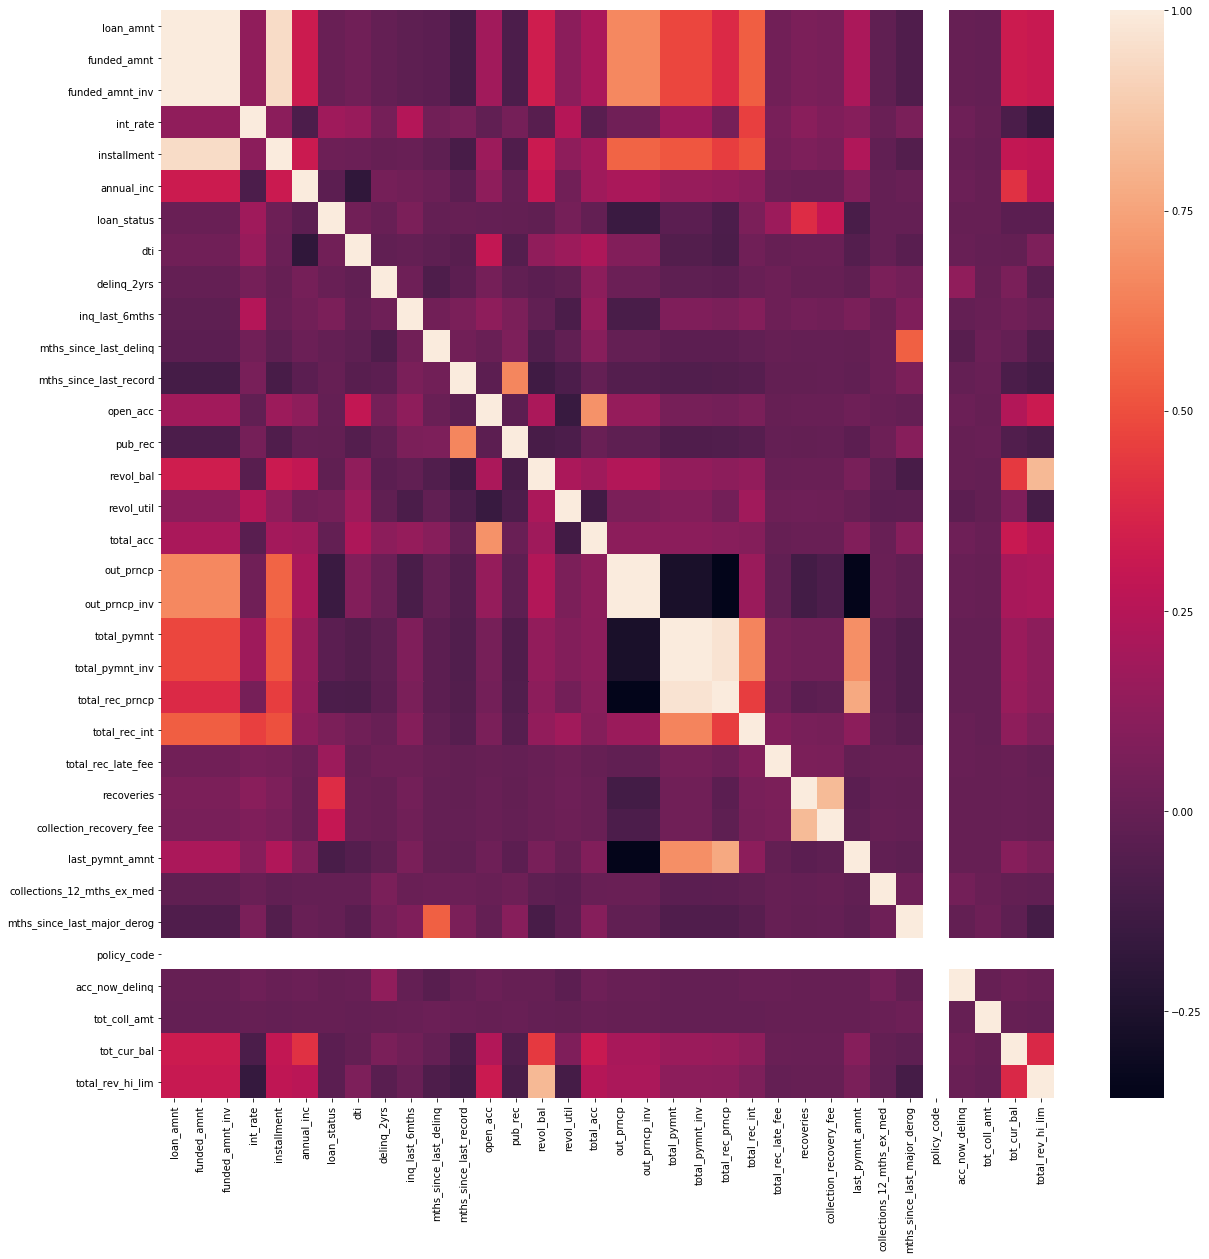

In [23]:
# Numerical correlation heat map
import seaborn as sns
corr = numeric_pd.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In this step we're using Variational Inflation Factor to further reduce columns. This is just one of many ways to determine co-variance and correlation between features. Ideally we would want to assume independence between the features for our modeling assumptions.

In [24]:
#from statsmodels.stats.outliers_influence import variance_inflation_factor    

#def calculate_vif_(X, thresh=5.0):
#    variables = list(range(X.shape[1]))
#    dropped = True
#    while dropped:
#        dropped = False
#        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
#               for ix in range(X.iloc[:, variables].shape[1])]

#        maxloc = vif.index(max(vif))
#        if max(vif) > thresh:
#            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
#                  '\' at index: ' + str(maxloc))
#            del variables[maxloc]
#            dropped = True

#    print('Remaining variables:')
#    print(X.columns[variables])
#    return X.iloc[:, variables]

In [25]:
#calculate_vif_(cat_num_pd,5.0)

Now that preprocessing is completed, we want to export all the relevant dataframes (numerical, categorical, numerical and categorical) so we reduce memory usage when we run our modeling scripts

In [26]:
cat_num_pd.to_csv('data/loan_preprocessed_all.csv')
numeric_pd.to_csv('data/loan_preprocessed_numerical.csv')
categorical_pd.to_csv('data/loan_preprocessed_categorical.csv')